In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import os
from functools import partial
from tensorflow import keras
import sys
sys.path.append("..")
from train_models import train_multihead_man, probe_dir
from data_prep import norm_image
from evaluate_models import plot_cm, process_labels, calc_precision_recall, calc_f1
from tensorboard.backend.event_processing.event_accumulator import EventAccumulator
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix
import time

In [2]:
X = np.load('../../data/galaxy_X.npy')
y = np.load('../../data/galaxy_y.npy')
y_man_aux = np.load('../../data/galaxy_y_manual_aux.npy')

In [3]:
#Set seeds to be able to reproduce network
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [4]:
X_tmp_train, X_test1, y_man_aux_tmp_train, y_man_aux_test1, y_tmp_train, y_test = train_test_split(X, y_man_aux, y, test_size=0.1, train_size=0.9, random_state=42, shuffle=True, stratify=y)
X_train1, X_val1, y_man_aux_train1, y_man_aux_val1, y_train, y_val = train_test_split(X_tmp_train, y_man_aux_tmp_train, y_tmp_train, test_size=0.11, train_size=0.89, random_state=42, shuffle=True, stratify=y_tmp_train)

In [5]:
# Apply normalization to samples
def normalize_images(X):
    return np.array(list(map(normalize_image, X)))
    
def normalize_image(img):
    bot = np.min(img)
    top = np.max(img)
    norm = (img - bot)/(top - bot)
    return norm

X_train = normalize_images(X_train1)
X_val = normalize_images(X_val1)
X_test = normalize_images(X_test1)

X_train = X_train[..., np.newaxis]
X_val = X_val[..., np.newaxis]
X_test = X_test[..., np.newaxis]

In [6]:
# Apply normalization to features to allow for sigmoid output
def normalize_targets(y):
    bot = np.min(y, axis=0)
    top = np.max(y, axis=0)
    norm = (y - bot)/(top - bot)
    return norm

y_man_aux_train = normalize_targets(y_man_aux_train1)
y_man_aux_val = normalize_targets(y_man_aux_val1)
y_man_aux_test = normalize_targets(y_man_aux_test1)

# Even weights

In [7]:
# Evenly weighted heads
runs = 20
total_loss = 0
total_lbl_entropy = 0
total_bent_entropy = 0
total_fr_mse = 0
total_cores_mse = 0
total_size_mse = 0
total_lbl_acc = 0
total_bent_acc = 0
total_fr_mae = 0
total_cores_mae = 0
total_size_mae = 0
elapsed = 0

# Execute a few runs of training the network
for run in range(1,runs+1):
    start = time.time()
    tmp_loss, tmp_lbl_entropy, tmp_bent_entropy, tmp_fr_mse, tmp_cores_mse, tmp_size_mse, tmp_lbl_acc, tmp_bent_acc, tmp_fr_mae, tmp_cores_mae, tmp_size_mae = train_multihead_man(X_train, y_train, y_man_aux_train,
                                          X_val, y_val, y_man_aux_val, X_test, y_test, y_man_aux_test, 0.5, 0.5, run)
    keras.backend.clear_session()
    end = time.time()
    elapsed += (end - start)
    total_loss += tmp_loss
    total_lbl_entropy += tmp_lbl_entropy
    total_bent_entropy += tmp_bent_entropy
    total_fr_mse += tmp_fr_mse
    total_cores_mse += tmp_cores_mse
    total_size_mse += tmp_size_mse
    total_lbl_acc += tmp_lbl_acc
    total_bent_acc += tmp_bent_acc
    total_fr_mae += tmp_fr_mae
    total_cores_mae += tmp_cores_mae
    total_size_mae += tmp_size_mae
avg_loss = total_loss/runs
avg_lbl_entropy = total_lbl_entropy/runs
avg_bent_entropy = total_bent_entropy/runs
avg_fr_mse = total_fr_mse/runs
avg_cores_mse = total_cores_mse/runs
avg_size_mse = total_size_mse/runs
avg_lbl_acc = total_lbl_acc/runs
avg_bent_acc = total_bent_acc/runs
avg_fr_mae = total_fr_mae/runs
avg_cores_mae = total_cores_mae/runs
avg_size_mae = total_size_mae/runs
avg_elapsed = elapsed/runs

Epoch 1/100
22/22 [==============================] - 17s 457ms/step - loss: 0.6889 - main_out_loss: 1.1551 - bent_out_loss: 0.6039 - fr_out_loss: 0.1036 - cores_out_loss: 0.0735 - size_out_loss: 0.1098 - main_out_categorical_accuracy: 0.5214 - bent_out_categorical_accuracy: 1.0000 - fr_out_mean_absolute_error: 0.2849 - cores_out_mean_absolute_error: 0.2253 - size_out_mean_absolute_error: 0.3045 - val_loss: 0.4755 - val_main_out_loss: 0.7971 - val_bent_out_loss: 0.4004 - val_fr_out_loss: 0.0884 - val_cores_out_loss: 0.0671 - val_size_out_loss: 0.0595 - val_main_out_categorical_accuracy: 0.6207 - val_bent_out_categorical_accuracy: 1.0000 - val_fr_out_mean_absolute_error: 0.2601 - val_cores_out_mean_absolute_error: 0.2278 - val_size_out_mean_absolute_error: 0.1939
Epoch 2/100
22/22 [==============================] - 10s 466ms/step - loss: 0.5247 - main_out_loss: 0.8785 - bent_out_loss: 0.4497 - fr_out_loss: 0.0951 - cores_out_loss: 0.0604 - size_out_loss: 0.0778 - main_out_categorical_acc

Epoch 12/100
22/22 [==============================] - 6s 267ms/step - loss: 0.1937 - main_out_loss: 0.2858 - bent_out_loss: 0.2482 - fr_out_loss: 0.0580 - cores_out_loss: 0.0409 - size_out_loss: 0.0592 - main_out_categorical_accuracy: 0.9017 - bent_out_categorical_accuracy: 1.0000 - fr_out_mean_absolute_error: 0.1800 - cores_out_mean_absolute_error: 0.1509 - size_out_mean_absolute_error: 0.1720 - val_loss: 0.2184 - val_main_out_loss: 0.3243 - val_bent_out_loss: 0.2843 - val_fr_out_loss: 0.0638 - val_cores_out_loss: 0.0579 - val_size_out_loss: 0.0440 - val_main_out_categorical_accuracy: 0.8736 - val_bent_out_categorical_accuracy: 1.0000 - val_fr_out_mean_absolute_error: 0.1783 - val_cores_out_mean_absolute_error: 0.1680 - val_size_out_mean_absolute_error: 0.1381
Epoch 13/100
22/22 [==============================] - 6s 268ms/step - loss: 0.1800 - main_out_loss: 0.2648 - bent_out_loss: 0.2272 - fr_out_loss: 0.0546 - cores_out_loss: 0.0414 - size_out_loss: 0.0576 - main_out_categorical_acc

22/22 [==============================] - 10s 451ms/step - loss: 0.5416 - main_out_loss: 0.9080 - bent_out_loss: 0.4632 - fr_out_loss: 0.0946 - cores_out_loss: 0.0642 - size_out_loss: 0.0788 - main_out_categorical_accuracy: 0.6581 - bent_out_categorical_accuracy: 1.0000 - fr_out_mean_absolute_error: 0.2599 - cores_out_mean_absolute_error: 0.2095 - size_out_mean_absolute_error: 0.2227 - val_loss: 0.3842 - val_main_out_loss: 0.6341 - val_bent_out_loss: 0.3403 - val_fr_out_loss: 0.0829 - val_cores_out_loss: 0.0555 - val_size_out_loss: 0.0584 - val_main_out_categorical_accuracy: 0.6667 - val_bent_out_categorical_accuracy: 1.0000 - val_fr_out_mean_absolute_error: 0.2174 - val_cores_out_mean_absolute_error: 0.1992 - val_size_out_mean_absolute_error: 0.1656
Epoch 3/100
22/22 [==============================] - 6s 265ms/step - loss: 0.4509 - main_out_loss: 0.7410 - bent_out_loss: 0.4175 - fr_out_loss: 0.0874 - cores_out_loss: 0.0563 - size_out_loss: 0.0818 - main_out_categorical_accuracy: 0.6937

Epoch 13/100
22/22 [==============================] - 6s 265ms/step - loss: 0.1688 - main_out_loss: 0.2403 - bent_out_loss: 0.2338 - fr_out_loss: 0.0575 - cores_out_loss: 0.0439 - size_out_loss: 0.0541 - main_out_categorical_accuracy: 0.9160 - bent_out_categorical_accuracy: 1.0000 - fr_out_mean_absolute_error: 0.1762 - cores_out_mean_absolute_error: 0.1613 - size_out_mean_absolute_error: 0.1616 - val_loss: 0.3404 - val_main_out_loss: 0.5512 - val_bent_out_loss: 0.3470 - val_fr_out_loss: 0.0618 - val_cores_out_loss: 0.0528 - val_size_out_loss: 0.0569 - val_main_out_categorical_accuracy: 0.8391 - val_bent_out_categorical_accuracy: 1.0000 - val_fr_out_mean_absolute_error: 0.1769 - val_cores_out_mean_absolute_error: 0.1641 - val_size_out_mean_absolute_error: 0.1753
Epoch 14/100
22/22 [==============================] - 6s 266ms/step - loss: 0.1703 - main_out_loss: 0.2456 - bent_out_loss: 0.2197 - fr_out_loss: 0.0617 - cores_out_loss: 0.0416 - size_out_loss: 0.0567 - main_out_categorical_acc

In [8]:
runs = 20
epochs_log = []
for run in range(1,runs+1):
    ea = EventAccumulator(f'../../lr_logs/man_multihead_0.5_0.5_run{run}/train')
    ea.Reload()
    ct_loss, epochs_loss, loss = zip(*ea.Tensors('epoch_loss'))
    epochs_loss = np.asarray(epochs_loss)
    epochs_log.append(epochs_loss[-1] + 1)

epochs_log = np.array(epochs_log)
avg_epochs = np.mean(epochs_log)
min_idx = np.argmin(epochs_log) + 1
min_epochs = epochs_log[min_idx - 1]
max_idx = np.argmax(epochs_log) + 1
max_epochs = epochs_log[max_idx - 1]

In [9]:
avg_mse = (avg_fr_mse + avg_cores_mse + avg_size_mse)/3
avg_mae = (avg_fr_mae + avg_cores_mae + avg_size_mae)/3
tmp = np.array([avg_lbl_entropy, avg_bent_entropy, avg_fr_mse, avg_cores_mse, avg_size_mse, avg_lbl_acc, avg_bent_acc, avg_fr_mae, avg_cores_mae, avg_size_mae, avg_mse, avg_mae, avg_loss, avg_elapsed, avg_epochs, max_epochs, max_idx, min_epochs, min_idx])
probe_dir('../../results/')
np.save('../../results/man_multihead_even_results.npy', tmp)
tmp = np.load('../../results/man_multihead_even_results.npy')

In [10]:
print(f"Average classification entropy: {tmp[0]}")
print(f"Average bent entropy: {tmp[1]}")
print(f"Average FR ratio MSE: {tmp[2]}")
print(f"Average core count MSE: {tmp[3]}")
print(f"Average core ratio MSE: {tmp[4]}")
print(f"Average classification accuracy: {tmp[5]}")
print(f"Average bent accuracy: {tmp[6]}")
print(f"Average FR ratio MAE: {tmp[7]}")
print(f"Average core count MAE: {tmp[8]}")
print(f"Average core ratio MAE: {tmp[9]}")
print(f"Average overall MSE: {tmp[10]}")
print(f"Average overall MAE: {tmp[11]}")
print(f"Average loss: {tmp[12]}")
print(f"Average time taken: {tmp[13]}")
print(f"Average epochs taken: {tmp[14]}")
print(f"Maximum number of epochs taken was {tmp[15]} at run {tmp[16]}")
print(f"Minimum number of epochs taken was {tmp[17]} at run {tmp[18]}")

Average classification entropy: 0.29574109613895416
Average bent entropy: 0.34865085780620575
Average FR ratio MSE: 0.06904822960495949
Average core count MSE: 0.12566691637039185
Average core ratio MSE: 0.10814103111624718
Average classification accuracy: 0.875
Average bent accuracy: 1.0
Average FR ratio MAE: 0.1917305514216423
Average core count MAE: 0.2571263164281845
Average core ratio MAE: 0.24357139319181442
Average overall MSE: 0.10095205903053284
Average overall MAE: 0.23080942034721375
Average loss: 0.22930891811847687
Average time taken: 147.0732822418213
Average epochs taken: 18.5
Maximum number of epochs taken was 20.0 at run 1.0
Minimum number of epochs taken was 17.0 at run 2.0


In [11]:
def extract_class_pred(preds):
    return preds[0]

Average bent precision: 0.8047619047619048
Average bent recall: 0.7857142857142857
Average bent F1: 0.7950058072009292
Average comp precision: 0.8814102564102564
Average comp recall: 1.0
Average comp F1: 0.9365942028985508
Average FRI precision: 1.0
Average FRI recall: 0.8888888888888888
Average FRI F1: 0.9411764705882353
Average FRII precision: 0.858974358974359
Average FRII recall: 0.881578947368421
Average FRII F1: 0.8701298701298701
Average Macro F1: 0.8857265877043963


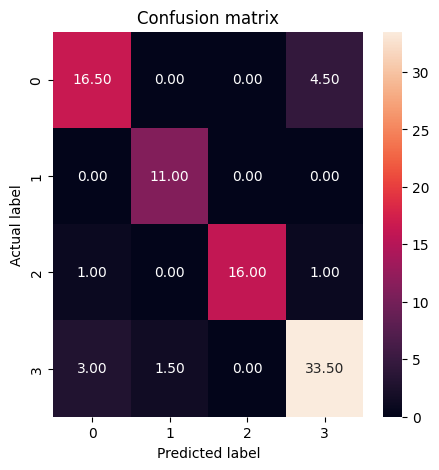

In [12]:
bent_precs, bent_recalls, bent_f1s = [], [], []
comp_precs, comp_recalls, comp_f1s = [], [], []
fri_precs, fri_recalls, fri_f1s = [], [], []
frii_precs, frii_recalls, frii_f1s = [], [], []
macro_f1s = []
average_cm = np.zeros((4, 4))
runs = 20
for run in range(1,runs+1):
    best_model = keras.models.load_model(f"../../models/man_multihead_0.5_0.5_model{run}.h5")
    test_pred = extract_class_pred(best_model.predict(X_test))
    new_test_true, new_test_pred = process_labels(y_test, test_pred)
    cm = confusion_matrix(new_test_true, new_test_pred)
    average_cm += cm
    bent_prec, bent_recall = calc_precision_recall(cm, 0)
    bent_precs.append(bent_prec)
    bent_recalls.append(bent_recall)
    bent_f1s.append(calc_f1(bent_prec, bent_recall))
    comp_prec, comp_recall = calc_precision_recall(cm, 1)
    comp_precs.append(comp_prec)
    comp_recalls.append(comp_recall)
    comp_f1s.append(calc_f1(comp_prec, comp_recall))
    fri_prec, fri_recall = calc_precision_recall(cm, 2)
    fri_precs.append(fri_prec)
    fri_recalls.append(fri_recall)
    fri_f1s.append(calc_f1(fri_prec, fri_recall))
    frii_prec, frii_recall = calc_precision_recall(cm, 3)
    frii_precs.append(frii_prec)
    frii_recalls.append(frii_recall)
    frii_f1s.append(calc_f1(frii_prec, frii_recall))
    macro_f1s.append((bent_f1s[-1] + comp_f1s[-1] + fri_f1s[-1] + frii_f1s[-1])/4)

average_cm = average_cm/runs
print(f'Average bent precision: {np.mean(bent_precs)}')
print(f'Average bent recall: {np.mean(bent_recalls)}')
print(f'Average bent F1: {np.mean(bent_f1s)}')
print(f'Average comp precision: {np.mean(comp_precs)}')
print(f'Average comp recall: {np.mean(comp_recalls)}')
print(f'Average comp F1: {np.mean(comp_f1s)}')
print(f'Average FRI precision: {np.mean(fri_precs)}')
print(f'Average FRI recall: {np.mean(fri_recalls)}')
print(f'Average FRI F1: {np.mean(fri_f1s)}')
print(f'Average FRII precision: {np.mean(frii_precs)}')
print(f'Average FRII recall: {np.mean(frii_recalls)}')
print(f'Average FRII F1: {np.mean(frii_f1s)}')
print(f'Average Macro F1: {np.mean(macro_f1s)}')
plot_cm(average_cm)

# Heavier auxiliary weights

In [13]:
# Aux weighted heads
runs = 20
total_loss = 0
total_lbl_entropy = 0
total_bent_entropy = 0
total_fr_mse = 0
total_cores_mse = 0
total_size_mse = 0
total_lbl_acc = 0
total_bent_acc = 0
total_fr_mae = 0
total_cores_mae = 0
total_size_mae = 0
elapsed = 0

# Execute a few runs of training the network
for run in range(1,runs+1):
    start = time.time()
    tmp_loss, tmp_lbl_entropy, tmp_bent_entropy, tmp_fr_mse, tmp_cores_mse, tmp_size_mse, tmp_lbl_acc, tmp_bent_acc, tmp_fr_mae, tmp_cores_mae, tmp_size_mae = train_multihead_man(X_train, y_train, y_man_aux_train,
                                          X_val, y_val, y_man_aux_val, X_test, y_test, y_man_aux_test, 0.25, 0.75, run)
    keras.backend.clear_session()
    end = time.time()
    elapsed += (end - start)
    total_loss += tmp_loss
    total_lbl_entropy += tmp_lbl_entropy
    total_bent_entropy += tmp_bent_entropy
    total_fr_mse += tmp_fr_mse
    total_cores_mse += tmp_cores_mse
    total_size_mse += tmp_size_mse
    total_lbl_acc += tmp_lbl_acc
    total_bent_acc += tmp_bent_acc
    total_fr_mae += tmp_fr_mae
    total_cores_mae += tmp_cores_mae
    total_size_mae += tmp_size_mae
avg_loss = total_loss/runs
avg_lbl_entropy = total_lbl_entropy/runs
avg_bent_entropy = total_bent_entropy/runs
avg_fr_mse = total_fr_mse/runs
avg_cores_mse = total_cores_mse/runs
avg_size_mse = total_size_mse/runs
avg_lbl_acc = total_lbl_acc/runs
avg_bent_acc = total_bent_acc/runs
avg_fr_mae = total_fr_mae/runs
avg_cores_mae = total_cores_mae/runs
avg_size_mae = total_size_mae/runs
avg_elapsed = elapsed/runs

Epoch 1/100
22/22 [==============================] - 9s 303ms/step - loss: 0.4686 - main_out_loss: 1.1848 - bent_out_loss: 0.6330 - fr_out_loss: 0.1039 - cores_out_loss: 0.0758 - size_out_loss: 0.1069 - main_out_categorical_accuracy: 0.5171 - bent_out_categorical_accuracy: 1.0000 - fr_out_mean_absolute_error: 0.2828 - cores_out_mean_absolute_error: 0.2207 - size_out_mean_absolute_error: 0.2915 - val_loss: 0.3157 - val_main_out_loss: 0.8025 - val_bent_out_loss: 0.4089 - val_fr_out_loss: 0.0897 - val_cores_out_loss: 0.0597 - val_size_out_loss: 0.0551 - val_main_out_categorical_accuracy: 0.6667 - val_bent_out_categorical_accuracy: 1.0000 - val_fr_out_mean_absolute_error: 0.2652 - val_cores_out_mean_absolute_error: 0.2065 - val_size_out_mean_absolute_error: 0.1707
Epoch 2/100
22/22 [==============================] - 10s 482ms/step - loss: 0.3545 - main_out_loss: 0.9100 - bent_out_loss: 0.4469 - fr_out_loss: 0.0945 - cores_out_loss: 0.0629 - size_out_loss: 0.0731 - main_out_categorical_accu

Epoch 12/100
22/22 [==============================] - 9s 437ms/step - loss: 0.1621 - main_out_loss: 0.3351 - bent_out_loss: 0.2577 - fr_out_loss: 0.0593 - cores_out_loss: 0.0437 - size_out_loss: 0.0573 - main_out_categorical_accuracy: 0.8960 - bent_out_categorical_accuracy: 1.0000 - fr_out_mean_absolute_error: 0.1816 - cores_out_mean_absolute_error: 0.1574 - size_out_mean_absolute_error: 0.1626 - val_loss: 0.1871 - val_main_out_loss: 0.4021 - val_bent_out_loss: 0.3006 - val_fr_out_loss: 0.0546 - val_cores_out_loss: 0.0557 - val_size_out_loss: 0.0508 - val_main_out_categorical_accuracy: 0.8161 - val_bent_out_categorical_accuracy: 1.0000 - val_fr_out_mean_absolute_error: 0.1724 - val_cores_out_mean_absolute_error: 0.1734 - val_size_out_mean_absolute_error: 0.1472
Epoch 13/100
22/22 [==============================] - 6s 258ms/step - loss: 0.1503 - main_out_loss: 0.2977 - bent_out_loss: 0.2392 - fr_out_loss: 0.0644 - cores_out_loss: 0.0429 - size_out_loss: 0.0579 - main_out_categorical_acc

Epoch 23/100
22/22 [==============================] - 6s 266ms/step - loss: 0.1023 - main_out_loss: 0.1673 - bent_out_loss: 0.1700 - fr_out_loss: 0.0508 - cores_out_loss: 0.0482 - size_out_loss: 0.0537 - main_out_categorical_accuracy: 0.9487 - bent_out_categorical_accuracy: 1.0000 - fr_out_mean_absolute_error: 0.1658 - cores_out_mean_absolute_error: 0.1602 - size_out_mean_absolute_error: 0.1547 - val_loss: 0.2135 - val_main_out_loss: 0.4775 - val_bent_out_loss: 0.3160 - val_fr_out_loss: 0.0717 - val_cores_out_loss: 0.0571 - val_size_out_loss: 0.0571 - val_main_out_categorical_accuracy: 0.8046 - val_bent_out_categorical_accuracy: 1.0000 - val_fr_out_mean_absolute_error: 0.1845 - val_cores_out_mean_absolute_error: 0.1601 - val_size_out_mean_absolute_error: 0.1626
Epoch 24/100
22/22 [==============================] - 6s 267ms/step - loss: 0.1025 - main_out_loss: 0.1766 - bent_out_loss: 0.1748 - fr_out_loss: 0.0498 - cores_out_loss: 0.0340 - size_out_loss: 0.0525 - main_out_categorical_acc

22/22 [==============================] - 6s 273ms/step - loss: 0.2099 - main_out_loss: 0.4602 - bent_out_loss: 0.3240 - fr_out_loss: 0.0629 - cores_out_loss: 0.0478 - size_out_loss: 0.0712 - main_out_categorical_accuracy: 0.8419 - bent_out_categorical_accuracy: 1.0000 - fr_out_mean_absolute_error: 0.1876 - cores_out_mean_absolute_error: 0.1700 - size_out_mean_absolute_error: 0.1899 - val_loss: 0.2450 - val_main_out_loss: 0.6094 - val_bent_out_loss: 0.3250 - val_fr_out_loss: 0.0575 - val_cores_out_loss: 0.0507 - val_size_out_loss: 0.0610 - val_main_out_categorical_accuracy: 0.7241 - val_bent_out_categorical_accuracy: 1.0000 - val_fr_out_mean_absolute_error: 0.1846 - val_cores_out_mean_absolute_error: 0.1739 - val_size_out_mean_absolute_error: 0.1936
Epoch 8/100
22/22 [==============================] - 6s 268ms/step - loss: 0.1838 - main_out_loss: 0.3902 - bent_out_loss: 0.2890 - fr_out_loss: 0.0648 - cores_out_loss: 0.0422 - size_out_loss: 0.0639 - main_out_categorical_accuracy: 0.8661 

Epoch 18/100
22/22 [==============================] - 6s 276ms/step - loss: 0.1062 - main_out_loss: 0.1968 - bent_out_loss: 0.1572 - fr_out_loss: 0.0557 - cores_out_loss: 0.0398 - size_out_loss: 0.0511 - main_out_categorical_accuracy: 0.9373 - bent_out_categorical_accuracy: 1.0000 - fr_out_mean_absolute_error: 0.1721 - cores_out_mean_absolute_error: 0.1488 - size_out_mean_absolute_error: 0.1496 - val_loss: 0.2025 - val_main_out_loss: 0.4169 - val_bent_out_loss: 0.3514 - val_fr_out_loss: 0.0626 - val_cores_out_loss: 0.0563 - val_size_out_loss: 0.0540 - val_main_out_categorical_accuracy: 0.8506 - val_bent_out_categorical_accuracy: 1.0000 - val_fr_out_mean_absolute_error: 0.1716 - val_cores_out_mean_absolute_error: 0.1559 - val_size_out_mean_absolute_error: 0.1642
Epoch 19/100
22/22 [==============================] - 10s 474ms/step - loss: 0.1031 - main_out_loss: 0.1868 - bent_out_loss: 0.1640 - fr_out_loss: 0.0451 - cores_out_loss: 0.0407 - size_out_loss: 0.0509 - main_out_categorical_ac

In [14]:
runs = 20
epochs_log = []
for run in range(1,runs+1):
    ea = EventAccumulator(f'../../lr_logs/man_multihead_0.25_0.75_run{run}/train')
    ea.Reload()
    ct_loss, epochs_loss, loss = zip(*ea.Tensors('epoch_loss'))
    epochs_loss = np.asarray(epochs_loss)
    epochs_log.append(epochs_loss[-1] + 1)

epochs_log = np.array(epochs_log)
avg_epochs = np.mean(epochs_log)
min_idx = np.argmin(epochs_log) + 1
min_epochs = epochs_log[min_idx - 1]
max_idx = np.argmax(epochs_log) + 1
max_epochs = epochs_log[max_idx - 1]

In [15]:
avg_mse = (avg_fr_mse + avg_cores_mse + avg_size_mse)/3
avg_mae = (avg_fr_mae + avg_cores_mae + avg_size_mae)/3
tmp = np.array([avg_lbl_entropy, avg_bent_entropy, avg_fr_mse, avg_cores_mse, avg_size_mse, avg_lbl_acc, avg_bent_acc, avg_fr_mae, avg_cores_mae, avg_size_mae, avg_mse, avg_mae, avg_loss, avg_elapsed, avg_epochs, max_epochs, max_idx, min_epochs, min_idx])
probe_dir('../../results/')
np.save('../../results/man_multihead_aux_results.npy', tmp)
tmp = np.load('../../results/man_multihead_aux_results.npy')

In [16]:
print(f"Average classification entropy: {tmp[0]}")
print(f"Average bent entropy: {tmp[1]}")
print(f"Average FR ratio MSE: {tmp[2]}")
print(f"Average core count MSE: {tmp[3]}")
print(f"Average core ratio MSE: {tmp[4]}")
print(f"Average classification accuracy: {tmp[5]}")
print(f"Average bent accuracy: {tmp[6]}")
print(f"Average FR ratio MAE: {tmp[7]}")
print(f"Average core count MAE: {tmp[8]}")
print(f"Average core ratio MAE: {tmp[9]}")
print(f"Average overall MSE: {tmp[10]}")
print(f"Average overall MAE: {tmp[11]}")
print(f"Average loss: {tmp[12]}")
print(f"Average time taken: {tmp[13]}")
print(f"Average epochs taken: {tmp[14]}")
print(f"Maximum number of epochs taken was {tmp[15]} at run {tmp[16]}")
print(f"Minimum number of epochs taken was {tmp[17]} at run {tmp[18]}")

Average classification entropy: 0.39094720780849457
Average bent entropy: 0.39039237797260284
Average FR ratio MSE: 0.07252342253923416
Average core count MSE: 0.12881749123334885
Average core ratio MSE: 0.0947192907333374
Average classification accuracy: 0.8522727489471436
Average bent accuracy: 1.0
Average FR ratio MAE: 0.19243402034044266
Average core count MAE: 0.25886185467243195
Average core ratio MAE: 0.2188103124499321
Average overall MSE: 0.09868673483530681
Average overall MAE: 0.2233687291542689
Average loss: 0.22644665092229843
Average time taken: 193.41297900676727
Average epochs taken: 25.0
Maximum number of epochs taken was 26.0 at run 1.0
Minimum number of epochs taken was 24.0 at run 2.0


Average bent precision: 0.7777777777777778
Average bent recall: 0.6666666666666666
Average bent F1: 0.717948717948718
Average comp precision: 0.9166666666666666
Average comp recall: 1.0
Average comp F1: 0.9565217391304348
Average FRI precision: 1.0
Average FRI recall: 0.8888888888888888
Average FRI F1: 0.9411764705882353
Average FRII precision: 0.8095238095238095
Average FRII recall: 0.8947368421052632
Average FRII F1: 0.8500000000000001
Average Macro F1: 0.8664117319168471


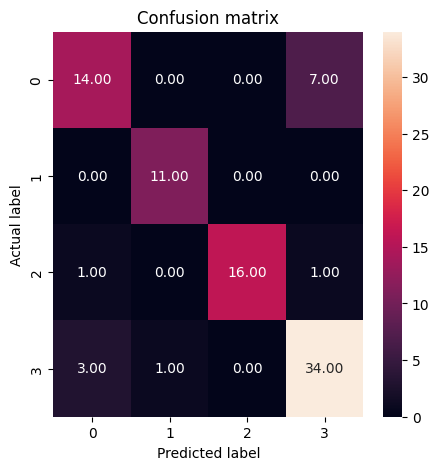

In [17]:
bent_precs, bent_recalls, bent_f1s = [], [], []
comp_precs, comp_recalls, comp_f1s = [], [], []
fri_precs, fri_recalls, fri_f1s = [], [], []
frii_precs, frii_recalls, frii_f1s = [], [], []
macro_f1s = []
average_cm = np.zeros((4, 4))
runs = 20
for run in range(1,runs+1):
    best_model = keras.models.load_model(f"../../models/man_multihead_0.25_0.75_model{run}.h5")
    test_pred = extract_class_pred(best_model.predict(X_test))
    new_test_true, new_test_pred = process_labels(y_test, test_pred)
    cm = confusion_matrix(new_test_true, new_test_pred)
    average_cm += cm
    bent_prec, bent_recall = calc_precision_recall(cm, 0)
    bent_precs.append(bent_prec)
    bent_recalls.append(bent_recall)
    bent_f1s.append(calc_f1(bent_prec, bent_recall))
    comp_prec, comp_recall = calc_precision_recall(cm, 1)
    comp_precs.append(comp_prec)
    comp_recalls.append(comp_recall)
    comp_f1s.append(calc_f1(comp_prec, comp_recall))
    fri_prec, fri_recall = calc_precision_recall(cm, 2)
    fri_precs.append(fri_prec)
    fri_recalls.append(fri_recall)
    fri_f1s.append(calc_f1(fri_prec, fri_recall))
    frii_prec, frii_recall = calc_precision_recall(cm, 3)
    frii_precs.append(frii_prec)
    frii_recalls.append(frii_recall)
    frii_f1s.append(calc_f1(frii_prec, frii_recall))
    macro_f1s.append((bent_f1s[-1] + comp_f1s[-1] + fri_f1s[-1] + frii_f1s[-1])/4)

average_cm = average_cm/runs
print(f'Average bent precision: {np.mean(bent_precs)}')
print(f'Average bent recall: {np.mean(bent_recalls)}')
print(f'Average bent F1: {np.mean(bent_f1s)}')
print(f'Average comp precision: {np.mean(comp_precs)}')
print(f'Average comp recall: {np.mean(comp_recalls)}')
print(f'Average comp F1: {np.mean(comp_f1s)}')
print(f'Average FRI precision: {np.mean(fri_precs)}')
print(f'Average FRI recall: {np.mean(fri_recalls)}')
print(f'Average FRI F1: {np.mean(fri_f1s)}')
print(f'Average FRII precision: {np.mean(frii_precs)}')
print(f'Average FRII recall: {np.mean(frii_recalls)}')
print(f'Average FRII F1: {np.mean(frii_f1s)}')
print(f'Average Macro F1: {np.mean(macro_f1s)}')
plot_cm(average_cm)

# Heavier main weights

In [18]:
# Main weighted heads
runs = 20
total_loss = 0
total_lbl_entropy = 0
total_bent_entropy = 0
total_fr_mse = 0
total_cores_mse = 0
total_size_mse = 0
total_lbl_acc = 0
total_bent_acc = 0
total_fr_mae = 0
total_cores_mae = 0
total_size_mae = 0
elapsed = 0

# Execute a few runs of training the network
for run in range(1,runs+1):
    start = time.time()
    tmp_loss, tmp_lbl_entropy, tmp_bent_entropy, tmp_fr_mse, tmp_cores_mse, tmp_size_mse, tmp_lbl_acc, tmp_bent_acc, tmp_fr_mae, tmp_cores_mae, tmp_size_mae = train_multihead_man(X_train, y_train, y_man_aux_train,
                                          X_val, y_val, y_man_aux_val, X_test, y_test, y_man_aux_test, 0.75, 0.25, run)
    keras.backend.clear_session()
    end = time.time()
    elapsed += (end - start)
    total_loss += tmp_loss
    total_lbl_entropy += tmp_lbl_entropy
    total_bent_entropy += tmp_bent_entropy
    total_fr_mse += tmp_fr_mse
    total_cores_mse += tmp_cores_mse
    total_size_mse += tmp_size_mse
    total_lbl_acc += tmp_lbl_acc
    total_bent_acc += tmp_bent_acc
    total_fr_mae += tmp_fr_mae
    total_cores_mae += tmp_cores_mae
    total_size_mae += tmp_size_mae
avg_loss = total_loss/runs
avg_lbl_entropy = total_lbl_entropy/runs
avg_bent_entropy = total_bent_entropy/runs
avg_fr_mse = total_fr_mse/runs
avg_cores_mse = total_cores_mse/runs
avg_size_mse = total_size_mse/runs
avg_lbl_acc = total_lbl_acc/runs
avg_bent_acc = total_bent_acc/runs
avg_fr_mae = total_fr_mae/runs
avg_cores_mae = total_cores_mae/runs
avg_size_mae = total_size_mae/runs
avg_elapsed = elapsed/runs

Epoch 1/100
22/22 [==============================] - 10s 322ms/step - loss: 0.9064 - main_out_loss: 1.1335 - bent_out_loss: 0.5945 - fr_out_loss: 0.1092 - cores_out_loss: 0.0809 - size_out_loss: 0.1158 - main_out_categorical_accuracy: 0.5328 - bent_out_categorical_accuracy: 1.0000 - fr_out_mean_absolute_error: 0.2941 - cores_out_mean_absolute_error: 0.2318 - size_out_mean_absolute_error: 0.3086 - val_loss: 0.5993 - val_main_out_loss: 0.7479 - val_bent_out_loss: 0.4060 - val_fr_out_loss: 0.0860 - val_cores_out_loss: 0.0587 - val_size_out_loss: 0.0631 - val_main_out_categorical_accuracy: 0.6552 - val_bent_out_categorical_accuracy: 1.0000 - val_fr_out_mean_absolute_error: 0.2560 - val_cores_out_mean_absolute_error: 0.2082 - val_size_out_mean_absolute_error: 0.1768
Epoch 2/100
22/22 [==============================] - 11s 493ms/step - loss: 0.6901 - main_out_loss: 0.8603 - bent_out_loss: 0.4738 - fr_out_loss: 0.0988 - cores_out_loss: 0.0636 - size_out_loss: 0.0821 - main_out_categorical_acc

Epoch 12/100
22/22 [==============================] - 6s 289ms/step - loss: 0.2212 - main_out_loss: 0.2605 - bent_out_loss: 0.2492 - fr_out_loss: 0.0580 - cores_out_loss: 0.0442 - size_out_loss: 0.0626 - main_out_categorical_accuracy: 0.9088 - bent_out_categorical_accuracy: 1.0000 - fr_out_mean_absolute_error: 0.1782 - cores_out_mean_absolute_error: 0.1588 - size_out_mean_absolute_error: 0.1724 - val_loss: 0.3027 - val_main_out_loss: 0.3654 - val_bent_out_loss: 0.3012 - val_fr_out_loss: 0.0548 - val_cores_out_loss: 0.0510 - val_size_out_loss: 0.0515 - val_main_out_categorical_accuracy: 0.8621 - val_bent_out_categorical_accuracy: 1.0000 - val_fr_out_mean_absolute_error: 0.1633 - val_cores_out_mean_absolute_error: 0.1597 - val_size_out_mean_absolute_error: 0.1560
Epoch 13/100
22/22 [==============================] - 6s 285ms/step - loss: 0.2055 - main_out_loss: 0.2414 - bent_out_loss: 0.2355 - fr_out_loss: 0.0560 - cores_out_loss: 0.0423 - size_out_loss: 0.0584 - main_out_categorical_acc

22/22 [==============================] - 10s 447ms/step - loss: 0.3454 - main_out_loss: 0.4196 - bent_out_loss: 0.3083 - fr_out_loss: 0.0705 - cores_out_loss: 0.0453 - size_out_loss: 0.0677 - main_out_categorical_accuracy: 0.8490 - bent_out_categorical_accuracy: 1.0000 - fr_out_mean_absolute_error: 0.1962 - cores_out_mean_absolute_error: 0.1660 - size_out_mean_absolute_error: 0.1753 - val_loss: 0.3446 - val_main_out_loss: 0.4204 - val_bent_out_loss: 0.3101 - val_fr_out_loss: 0.0567 - val_cores_out_loss: 0.0497 - val_size_out_loss: 0.0516 - val_main_out_categorical_accuracy: 0.8506 - val_bent_out_categorical_accuracy: 1.0000 - val_fr_out_mean_absolute_error: 0.1797 - val_cores_out_mean_absolute_error: 0.1802 - val_size_out_mean_absolute_error: 0.1531
Epoch 8/100
22/22 [==============================] - 10s 452ms/step - loss: 0.3121 - main_out_loss: 0.3751 - bent_out_loss: 0.3133 - fr_out_loss: 0.0644 - cores_out_loss: 0.0442 - size_out_loss: 0.0702 - main_out_categorical_accuracy: 0.867

Epoch 18/100
22/22 [==============================] - 6s 289ms/step - loss: 0.1534 - main_out_loss: 0.1755 - bent_out_loss: 0.1970 - fr_out_loss: 0.0524 - cores_out_loss: 0.0429 - size_out_loss: 0.0561 - main_out_categorical_accuracy: 0.9330 - bent_out_categorical_accuracy: 1.0000 - fr_out_mean_absolute_error: 0.1699 - cores_out_mean_absolute_error: 0.1531 - size_out_mean_absolute_error: 0.1597 - val_loss: 0.2787 - val_main_out_loss: 0.3322 - val_bent_out_loss: 0.3124 - val_fr_out_loss: 0.0616 - val_cores_out_loss: 0.0531 - val_size_out_loss: 0.0453 - val_main_out_categorical_accuracy: 0.8966 - val_bent_out_categorical_accuracy: 1.0000 - val_fr_out_mean_absolute_error: 0.1684 - val_cores_out_mean_absolute_error: 0.1655 - val_size_out_mean_absolute_error: 0.1376
Epoch 19/100
22/22 [==============================] - 10s 462ms/step - loss: 0.1577 - main_out_loss: 0.1819 - bent_out_loss: 0.1902 - fr_out_loss: 0.0510 - cores_out_loss: 0.0362 - size_out_loss: 0.0628 - main_out_categorical_ac

In [19]:
runs = 20
epochs_log = []
for run in range(1,runs+1):
    ea = EventAccumulator(f'../../lr_logs/man_multihead_0.75_0.25_run{run}/train')
    ea.Reload()
    ct_loss, epochs_loss, loss = zip(*ea.Tensors('epoch_loss'))
    epochs_loss = np.asarray(epochs_loss)
    epochs_log.append(epochs_loss[-1] + 1)

epochs_log = np.array(epochs_log)
avg_epochs = np.mean(epochs_log)
min_idx = np.argmin(epochs_log) + 1
min_epochs = epochs_log[min_idx - 1]
max_idx = np.argmax(epochs_log) + 1
max_epochs = epochs_log[max_idx - 1]

In [20]:
avg_mse = (avg_fr_mse + avg_cores_mse + avg_size_mse)/3
avg_mae = (avg_fr_mae + avg_cores_mae + avg_size_mae)/3
tmp = np.array([avg_lbl_entropy, avg_bent_entropy, avg_fr_mse, avg_cores_mse, avg_size_mse, avg_lbl_acc, avg_bent_acc, avg_fr_mae, avg_cores_mae, avg_size_mae, avg_mse, avg_mae, avg_loss, avg_elapsed, avg_epochs, max_epochs, max_idx, min_epochs, min_idx])
probe_dir('../../results/')
np.save('../../results/man_multihead_main_results.npy', tmp)
tmp = np.load('../../results/man_multihead_main_results.npy')

In [21]:
print(f"Average classification entropy: {tmp[0]}")
print(f"Average bent entropy: {tmp[1]}")
print(f"Average FR ratio MSE: {tmp[2]}")
print(f"Average core count MSE: {tmp[3]}")
print(f"Average core ratio MSE: {tmp[4]}")
print(f"Average classification accuracy: {tmp[5]}")
print(f"Average bent accuracy: {tmp[6]}")
print(f"Average FR ratio MAE: {tmp[7]}")
print(f"Average core count MAE: {tmp[8]}")
print(f"Average core ratio MAE: {tmp[9]}")
print(f"Average overall MSE: {tmp[10]}")
print(f"Average overall MAE: {tmp[11]}")
print(f"Average loss: {tmp[12]}")
print(f"Average time taken: {tmp[13]}")
print(f"Average epochs taken: {tmp[14]}")
print(f"Maximum number of epochs taken was {tmp[15]} at run {tmp[16]}")
print(f"Minimum number of epochs taken was {tmp[17]} at run {tmp[18]}")

Average classification entropy: 0.34269802272319794
Average bent entropy: 0.3604249507188797
Average FR ratio MSE: 0.06457777135074139
Average core count MSE: 0.11815785989165306
Average core ratio MSE: 0.10085112974047661
Average classification accuracy: 0.8636363744735718
Average bent accuracy: 1.0
Average FR ratio MAE: 0.18010880053043365
Average core count MAE: 0.26203450560569763
Average core ratio MAE: 0.23495320975780487
Average overall MSE: 0.09452892032762368
Average overall MAE: 0.22569883863131204
Average loss: 0.29727424681186676
Average time taken: 159.9247646331787
Average epochs taken: 19.5
Maximum number of epochs taken was 24.0 at run 2.0
Minimum number of epochs taken was 15.0 at run 1.0


Average bent precision: 0.8284313725490196
Average bent recall: 0.6904761904761905
Average bent F1: 0.7530364372469635
Average comp precision: 0.9583333333333333
Average comp recall: 1.0
Average comp F1: 0.9782608695652174
Average FRI precision: 1.0
Average FRI recall: 0.8888888888888888
Average FRI F1: 0.9411764705882353
Average FRII precision: 0.8023255813953488
Average FRII recall: 0.9078947368421053
Average FRII F1: 0.8518518518518517
Average Macro F1: 0.881081407313067


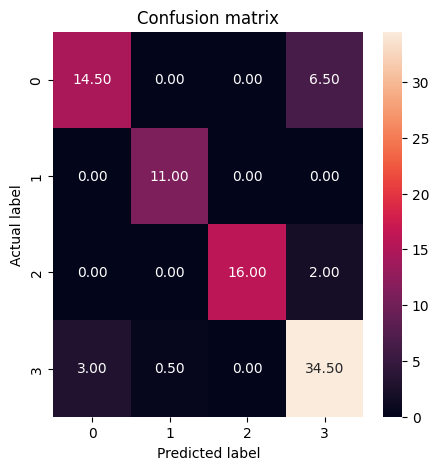

In [22]:
bent_precs, bent_recalls, bent_f1s = [], [], []
comp_precs, comp_recalls, comp_f1s = [], [], []
fri_precs, fri_recalls, fri_f1s = [], [], []
frii_precs, frii_recalls, frii_f1s = [], [], []
macro_f1s = []
average_cm = np.zeros((4, 4))
runs = 20
for run in range(1,runs+1):
    best_model = keras.models.load_model(f"../../models/man_multihead_0.75_0.25_model{run}.h5")
    test_pred = extract_class_pred(best_model.predict(X_test))
    new_test_true, new_test_pred = process_labels(y_test, test_pred)
    cm = confusion_matrix(new_test_true, new_test_pred)
    average_cm += cm
    bent_prec, bent_recall = calc_precision_recall(cm, 0)
    bent_precs.append(bent_prec)
    bent_recalls.append(bent_recall)
    bent_f1s.append(calc_f1(bent_prec, bent_recall))
    comp_prec, comp_recall = calc_precision_recall(cm, 1)
    comp_precs.append(comp_prec)
    comp_recalls.append(comp_recall)
    comp_f1s.append(calc_f1(comp_prec, comp_recall))
    fri_prec, fri_recall = calc_precision_recall(cm, 2)
    fri_precs.append(fri_prec)
    fri_recalls.append(fri_recall)
    fri_f1s.append(calc_f1(fri_prec, fri_recall))
    frii_prec, frii_recall = calc_precision_recall(cm, 3)
    frii_precs.append(frii_prec)
    frii_recalls.append(frii_recall)
    frii_f1s.append(calc_f1(frii_prec, frii_recall))
    macro_f1s.append((bent_f1s[-1] + comp_f1s[-1] + fri_f1s[-1] + frii_f1s[-1])/4)

average_cm = average_cm/runs
print(f'Average bent precision: {np.mean(bent_precs)}')
print(f'Average bent recall: {np.mean(bent_recalls)}')
print(f'Average bent F1: {np.mean(bent_f1s)}')
print(f'Average comp precision: {np.mean(comp_precs)}')
print(f'Average comp recall: {np.mean(comp_recalls)}')
print(f'Average comp F1: {np.mean(comp_f1s)}')
print(f'Average FRI precision: {np.mean(fri_precs)}')
print(f'Average FRI recall: {np.mean(fri_recalls)}')
print(f'Average FRI F1: {np.mean(fri_f1s)}')
print(f'Average FRII precision: {np.mean(frii_precs)}')
print(f'Average FRII recall: {np.mean(frii_recalls)}')
print(f'Average FRII F1: {np.mean(frii_f1s)}')
print(f'Average Macro F1: {np.mean(macro_f1s)}')
plot_cm(average_cm)